# Generating true time series data

An essential part of estimating detection power is creating a "True receptor concentration time series", that is a time series of the concentration without any of the noise.

Before we get too far, lets set up the notebook and import the required packages.

In [40]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from komanawa.gw_detect_power import DetectionPowerSlope
from scipy.interpolate import interp1d

## Bespoke time series data

Bespoke time series data needs to be re-sampled to the sampling frequency that you want to use for the detection power analysis.  The pandas library has a number of functions that can be used to do this. Just recall that the detection power analysis assumes a regular sampling frequency.

For instance, below we create a weekly time series for 10 years with a linear decreasing trend. We then resample this to a monthly frequency.

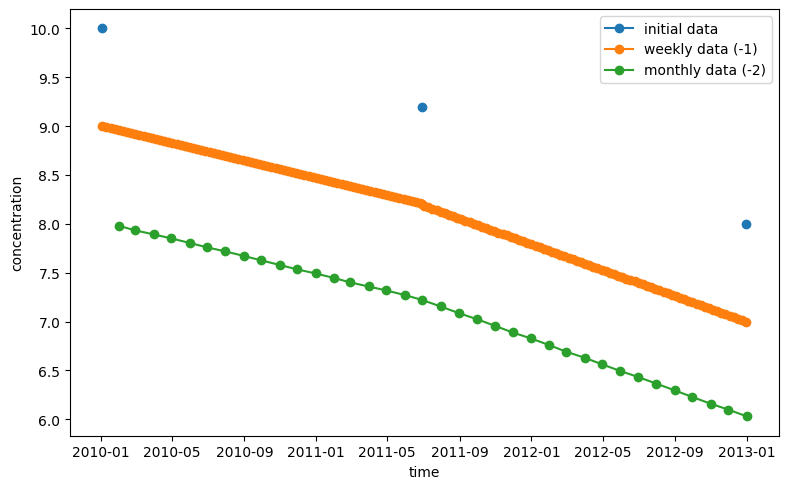

In [48]:
# make a time series with a non-monotonic linear decreasing trend
initial_data = pd.Series(index=pd.date_range(start='2010-01-03', end='2012-12-31', freq='W'))
initial_data.loc['2010-01-03'] = 10
initial_data.loc['2011-06-30'] = 9.2
initial_data.loc['2012-12-30'] = 8
initial_data = initial_data.sort_index()

# fill the missing values with linear interpolation
interpolated_data = initial_data.interpolate(method='linear')

# resample to a monthly frequency
monthly_data = interpolated_data.resample('ME').mean()

# plot the data
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(initial_data.index, initial_data, label='initial data', marker='o')
ax.plot(interpolated_data.index, interpolated_data - 1, label='weekly data (-1)', marker='o')
ax.plot(monthly_data.index, monthly_data - 2, label='monthly data (-2)', marker='o')
ax.set_xlabel('time')
ax.set_ylabel('concentration')
ax.legend()
fig.tight_layout()
plt.show()

### Transition date to years since sampling began
The detection power calculator operates in a float years format.  So time series data needs to be transitioned to this format.  Options include resampling as a timeseries then converting:

In [42]:
monthly_data = interpolated_data.resample('ME').mean()
x = (monthly_data.index - monthly_data.index.min()).days / 365.25

Alternatively, you can transition to years from the start of the time series early and use scipy.interpolate.interp1d to interpolate the data to the required sampling frequency.  This is a nice easy option if you want to resample to multiple frequencies.

In [43]:
x = (interpolated_data.index - interpolated_data.index.min()).days / 365.25
sampler = interp1d(x, interpolated_data.values, bounds_error=False, fill_value='extrapolate')
x_new = np.linspace(0, 3, 3 * 12)  # monthly sampling for 3 years
monthly_data = sampler(x_new)


The downside is you need to account for the impacts of lag by yourself.


## Piston flow model

the "truets_from_piston_flow" function allows the user to generate time series data from the piston flow model.

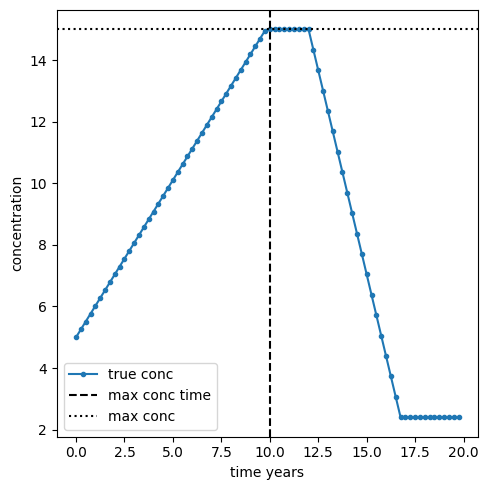

In [44]:
dpc = DetectionPowerSlope()
output = dpc.truets_from_piston_flow(mrt=12, initial_conc=5, target_conc=2.4,
                                     prev_slope=1, max_conc=15, samp_per_year=4, samp_years=20,
                                     implementation_time=5)
true_conc_ts = output[0]
max_conc = output[1]
max_conc_time = output[2]
frac_p2 = output[3]  # dummy value as this is a piston flow model
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(np.arange(len(true_conc_ts)) / 4, true_conc_ts, label='true conc', marker='.')
ax.axvline(max_conc_time, color='k', linestyle='--', label='max conc time')
ax.axhline(max_conc, color='k', linestyle=':', label='max conc')
ax.set_xlabel('time years')
ax.set_ylabel('concentration')
ax.legend()
fig.tight_layout()
plt.show()

Note that the piston flow model does not allow groundwater of different ages to mix, it simply sets a step lag time for the concentration to reach the receptor.  

# Binary piston flow model

More usefully, the binary piston flow model can be used to generate time series data that accounts for the mixing of groundwater of different ages.  The "truets_from_binary_exp_piston_flow" function allows the user to generate time series data from the binary piston flow model.


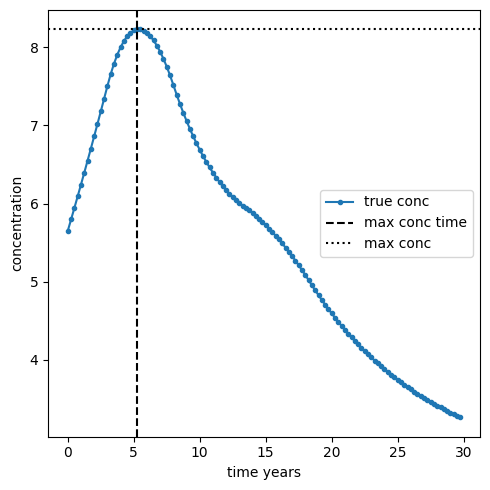

In [45]:
dpc = DetectionPowerSlope()
output = dpc.truets_from_binary_exp_piston_flow(mrt=15,
                                                mrt_p1=10,
                                                frac_p1=0.7,
                                                f_p1=0.7, f_p2=0.5,
                                                initial_conc=5.6, target_conc=2.4,
                                                prev_slope=0.5,
                                                max_conc=20,
                                                min_conc=1,
                                                samp_per_year=4, samp_years=30,
                                                implementation_time=5, past_source_data=None,
                                                return_extras=False, low_mem=False,
                                                precision=2)

true_conc_ts = output[0]
max_conc = output[1]
max_conc_time = output[2]
frac_p2 = output[3]
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(np.arange(len(true_conc_ts)) / 4, true_conc_ts, label='true conc', marker='.')
ax.axvline(max_conc_time, color='k', linestyle='--', label='max conc time')
ax.axhline(max_conc, color='k', linestyle=':', label='max conc')
ax.set_xlabel('time years')
ax.set_ylabel('concentration')
ax.legend()
fig.tight_layout()
plt.show()
plt.close(fig)

## Auto mode generation

The Auto classes (AutoDetectionPowerSlope & AutoDetectionPowerCounterFactual) facilitate the generation of time series as part
of the detection power analysis call.  The user specifies:

* an initial concentration
* a target concentration
* implementation time 
* sampling frequency
* sampling duration
* the slope of the previous data
* the maximum concentration limit
* the minimum concentration limit
* the model to use for the mean residence time (piston flow or binary exponential piston flow)
* the mean residence time and other parameters for the age model

The auto function then generates a source time series, propagates it onto the receptor (via the age model) and resamples it to the expected frequency.

## predicting a complex source time series to a receptor time series with Binary exponential piston flow model

the examples above show simple linear changes in the source concentration.  Instead, you may also pass a more complex source time series and propagate that to the receptor via a piston flow model.  The example below shows how to do this. The "True" concentration time series can then be resampled to the expected frequency and used in the detection power analysis.

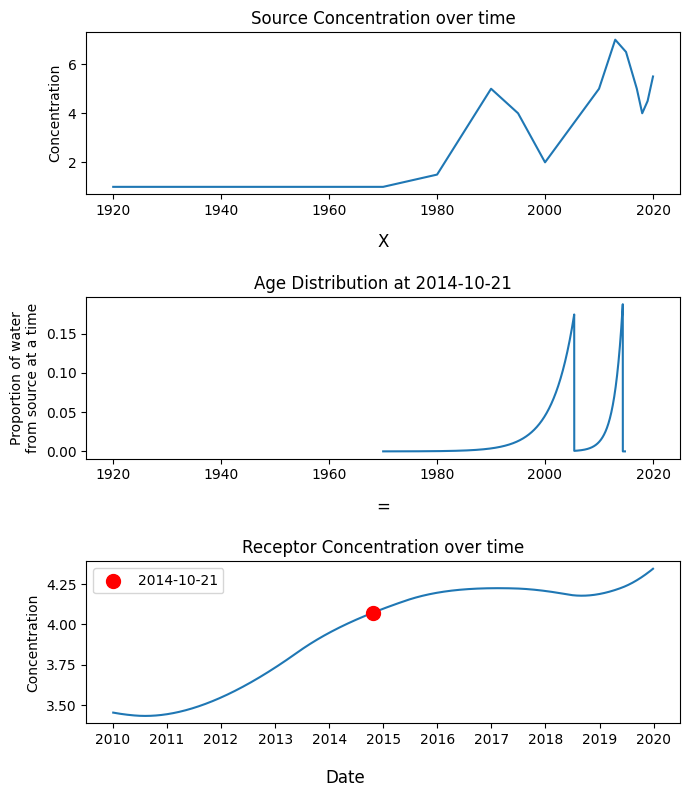

In [46]:
from komanawa.gw_age_tools import predict_future_conc_bepm, binary_exp_piston_flow, check_age_inputs


# make a quick function to convert ages to dates
def convert_to_dt(ages):
    return pd.to_timedelta(ages * 365, unit='D') + pd.to_datetime('2020-01-01')

# create a source time series
once_and_future_source_conc = pd.Series({
    -100: 1,
    -60: 1,
    -50.: 1,
    -40: 1.5,
    -30: 5,
    -25: 4,
    -20: 2,
    -10: 5,
    -7: 7,
    -5: 6.5,
    -3: 5,
    -2: 4,
    -1: 4.5,
    0: 5.5,
})

# set up the parameters for the age model
mrt = 10
mrt_p1 = 2
frac_p1 = 0.3
precision = 2
mrt_p2 = None
f_p1 = 0.8
f_p2 = 0.3

# check the inputs and calculate mrt_p2 if not provided
mrt, mrt_p2 = check_age_inputs(mrt, mrt_p1, mrt_p2, frac_p1, precision, f_p1, f_p2)

# predict the receptor time series
predict_start = -10
predict_stop = 0
recptor = predict_future_conc_bepm(once_and_future_source_conc, predict_start, predict_stop,
                                   mrt_p1, frac_p1, f_p1, f_p2, mrt=mrt, mrt_p2=mrt_p2, fill_value=1)

# plot the source and receptor time series
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(7, 8), sharex=False)
ax2.sharex(ax1)
ax1.plot(convert_to_dt(once_and_future_source_conc.index), once_and_future_source_conc.values)
ax1.set_ylabel('Concentration')
ax1.set_title('Source Concentration over time')

ax3.plot(convert_to_dt(recptor.index), recptor.values)
ax3.set_ylabel('Concentration')
ax3.set_title('=\n\nReceptor Concentration over time')
ax3.scatter(convert_to_dt(-5.2), recptor.loc[-5.2], color='r', marker='o', s=100, zorder=5,
            label=convert_to_dt(-5.2).date())
ax3.legend()

ages = np.arange(0, 50 - 5.2, 0.01)
pdf = binary_exp_piston_flow(ages, mrt_p1, mrt_p2, frac_p1, f_p1, f_p2, )
ax2.plot(convert_to_dt(ages * -1 + -5.2), pdf, label='PDF')
ax2.set_ylabel('Proportion of water\nfrom source at a time')
ax2.set_title(f'X\n\nAge Distribution at {convert_to_dt(-5.2).date()}')

fig.supxlabel('Date')
fig.tight_layout()
plt.show()


